# Lab 6b: Binomial Lattice Models of Equity Share Price
A binomial lattice model assumes that at each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$ in the next time interval. Thus, each discrete time interval can be modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.svg" width="280"/>
    </center>
</div>

while each level (time slice) of the tree is described by a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Different models have been developed to compute the tuple $(u,d,p)$. However, for now, let's analyze historical data and learn typical values governing the price movement for each firm in our historical dataset.  

## Learning Objectives
The objective of `L6b` is to familiarize students with the application of simple probability mass functions to predict future uncertain quantities such as commodity prices, equity share prices, interest rates, etc. In particular, in `L6b`, we will:

* __Objective 1__: Estimate values for the tuple $(u,d,p)$ using historical data for the share price of different firms (real-world probanbility measure).  
* __Objective 2__: Compare bionomial lattice model simulations of share price versus historical data

## Tasks
* __Prerequisite__ (duration 10 min): Break up into teams and familiarize yourself with the lab, it's setup, packages, types, functions, etc. Report back to the class any questions that your group has.
* __Task 1__ (duration 15 min): Walk through the pricing example from Hull. Report back to class any questions that your team has. 
* __Task 2__ (duration 5 min): Load the historical data set and familiarize yourself with its contents. Report back to class any questions that your team has.


## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality.

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the lattice model simulation of equity share prices:

The `MyBinomialEquityPriceTree` encodes the lattice model and has the fields:
    
* The `connectivity::Union{Nothing, Dict{Int64, Array{Int64,1}}}` field holds the indexes of the children for each parent node of the tree.
* The `levels::Union{Nothing, Dict{Int64,Array{Int64,1}}}` field holds indexes of nodes that belong to each level of the tree, i.e., a particular trading day.
* The `u::Float64` field holds the value of the `up` factor
* The `d::Float64` field holds the value of the `down` factor
* The `p::Float64` field holds the value of the probability of an `up` move.
* The `data::Union{Nothing, Dict{Int64, MyBiomialLatticeEquityNodeModel}}` holds each node in the tree; nodes are of type `MyBiomialLatticeEquityNodeModel`

Each node in the tree is a `MyBiomialLatticeEquityNodeModel` type. The `MyBiomialLatticeEquityNodeModel` has two important fields:
* The `price::Float64` field holds the price value for a node
* The `probability::Float64` field holds the probability value associated with this node

### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`MyPortfolioDataSet() |> x-> x["dataset"] -> DataFrame` 
 > This function loads historical share price data. The historical share price data is returned to the caller as a Dictionary of [DataFrames](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`. 
 
`function analyze(R::Array{Float64,1};  Δt::Float64 = (1.0/252.0)) -> Tuple{Float64,Float64,Float64}`
> The `analyze(...)` function takes an array of logarithmic return values in the `R` argument and a value of the time-step size of the simulation in the $\Delta{t}$ parameter (default value of 1-day) and returns estimated values for the lattice model parameters $(u,d,p)$.  
 
`function build(model::Type{MyBinomialEquityPriceTree}, data::NamedTuple) -> MyBinomialEquityPriceTree` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(u,d,p)$ values) and returns an instance of the `MyBinomialEquityPriceTree` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). Note: the `MyBinomialEquityPriceTree` returned from the `build(...)` function does not have price or probability information computed yet. Call the `populate(…)` function to populate this data.

`function populate(model::MyBinomialEquityPriceTree, Sₒ::Float64, h::Int) -> MyBinomialEquityPriceTree`
> The `populate(...)` function takes the `model::MyBinomialEquityPriceTree` instance returned from `build(...)`, a starting share price $S_{o}$ and the height of the tree, i.e., the number of time steps to simulate, and returns an updated `model::MyBinomialEquityPriceTree` instance with the price and probabilities computed for each node in the tree.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Labs-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Installed PDMats ──────── v0.11.19
   Installed StatsBase ───── v0.34.2
   Installed Distributions ─ v0.25.101
   Installed JuMP ────────── v1.15.1
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
    Updating `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  [34da2185] ↑ Comp

#### Constants

In [2]:
max_number_of_records = 1256;
Δt = (1/252);
TSIM = 21;

## Task 1: Test lattice model using example from Hull
Let’s start by calculating the hypothetical share price from an example (reproduced from Chapter 13 of Hull) before diving into historical data analysis. The lattice in this example has three levels (`L=0,1,2`), with an initial share price of $S_{\circ}=20.0$ USD. An `up` move has a probability of `p = 0.6523` and a magnitude of `u = 1.1`, while a `down` move has a magnitude of  `d = 0.9`.

### Implementation
Calculating the future share price with a binomial lattice requires setting the model’s parameters, including the initial share price (as a `Float64`), the number of time steps to simulate into the future, which equals the number levels of the tree starting from zero (as an `Int64`), the up and down move magnitudes (as `Float64` values), and the probability of an up move (as a `Float64`):

In [3]:
Sₒ,T,u,d,p = 20.0,2,1.1,0.9,0.6523;

Once these values are set, we use the `build(…)` function to create an empty lattice model of type `MyBinomialEquityPriceTree`, which is then passed to the `populate(…)` function using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>`. The `populate(…)` function calculates the prices and probabilities of each node (type `MyBiomialLatticeEquityNodeModel`) in the tree:

In [4]:
test_model = build(MyBinomialEquityPriceTree, (
        u = u, d = d, p = p)) |> (x-> populate(x, Sₒ = Sₒ, h = T));

Finally, we compare the price values we calculated to those reported by Hull. First, we populate the `hull_price_dictionary` dictionary with the price values at each node in the tree:

In [5]:
hull_price_dictionary = Dict(0=>20.0, 1=>22.0,2=>18.0,3=>24.2,4=>19.8,5=>16.2);

Next, we compare the `Hull` values to those we just calculated. We populate the `hull_test_data_table`, which is of type `DataFrame`, using a `for` loop:

In [6]:
number_of_nodes = length(test_model.data);
hull_test_data_table = DataFrame();
for i ∈ 0:(number_of_nodes-1)
    
    row_data = (
        index = i,
        hull_price = hull_price_dictionary[i],
        our_price = test_model.data[i].price, 
        isapproxequal = isapprox(hull_price_dictionary[i], test_model.data[i].price, rtol=1e-4)
    );
    
    push!(hull_test_data_table, row_data)
end

In [7]:
hull_test_data_table

6×4 DataFrame
 Row │ index  hull_price  our_price  isapproxequal 
     │ Int64  Float64     Float64    Bool          
─────┼─────────────────────────────────────────────
   1 │     0        20.0       20.0           true
   2 │     1        22.0       22.0           true
   3 │     2        18.0       18.0           true
   4 │     3        24.2       24.2           true
   5 │     4        19.8       19.8           true
   6 │     5        16.2       16.2           true

Q1.1 (Conceptual): Can you visualize this lattice? What would be the total number of nodes if this were extended another level?

## Task 2: Load historical equity dataset, select a random firm
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). However, not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or delisted, etc. We will exclude these firms from the `dataset`. We load the price `dataset` by calling the `MyPortfolioDataSet()` function:

In [8]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

The all keys array holds the list of firm indexes in the dataset that have complete data, i.e., all `1256` data values: 

In [10]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Let's select a random firm with `firm_index` to explore in this study by calling the `rand` function of the keys of the `dataset` dictionary, and then pull the histiorical data out of `dataset` that associated with this firm and store it in the variable `firm_data`:

In [11]:
random_firm_index = list_of_all_firms |> rand;

However, while it is sometimes convenient to work with the data using the `random_firm_index`, often we specify the [ticker symbol](https://en.wikipedia.org/wiki/Ticker_symbol#:~:text=A%20ticker%20symbol%20or%20stock,on%20a%20particular%20stock%20market.) instead. To facilitate this, let's load a mapping between the `random_firm_index` and the ticker symbols using the `MyFirmMappingDataSet()` function. We store this mapping in the `firm_mapping_df` variable, which is of type `DataFrame`:

In [12]:
firm_mapping_df = MyFirmMappingDataSet()

505×3 DataFrame
 Row │ Symbol   Name                    Sector                 
     │ String7  String                  String31               
─────┼─────────────────────────────────────────────────────────
   1 │ MMM      3M                      Industrials
   2 │ AOS      A. O. Smith             Industrials
   3 │ ABT      Abbott Laboratories     Health Care
   4 │ ABBV     AbbVie                  Health Care
   5 │ ABMD     Abiomed                 Health Care
   6 │ ACN      Accenture               Information Technology
   7 │ ATVI     Activision Blizzard     Communication Services
   8 │ ADM      ADM                     Consumer Staples
   9 │ ADBE     Adobe                   Information Technology
  10 │ AAP      Advance Auto Parts      Consumer Discretionary
  11 │ AMD      Advanced Micro Devices  Information Technology
  ⋮  │    ⋮               ⋮                       ⋮
 496 │ WLTW     Willis Towers Watson    Financials
 497 │ WYNN     Wynn Resorts            Consumer Discretionary
 498 │ XEL      Xcel Energy             Utilities
 499 │ XLNX     Xilinx                  Information Technology
 500 │ XYL      Xylem                   Industrials
 501 │ YUM      Yum! Brands             Consumer Discretionary
 502 │ ZBRA     Zebra Technologies      Information Technology
 503 │ ZBH      Zimmer Biomet           Health Care
 504 │ ZION     Zions Bancorp           Financials
 505 │ ZTS      Zoetis                  Health Care
                                               484 rows omitted

In [13]:
random_firm_data = dataset[random_firm_index]

1256×7 DataFrame
  Row │ volume     volume_weighted_average_price  open     close    high     l ⋯
      │ Float64    Float64                        Float64  Float64  Float64  F ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 4.1149e6                         47.7439    47.57    47.49   48.03     ⋯
    2 │ 2.80702e6                        47.4596    47.3     47.12   47.86
    3 │ 3.72799e6                        46.8464    47.18    46.79   47.35
    4 │ 3.8376e6                         46.9486    46.88    47.14   47.21
    5 │ 3.00628e6                        46.6305    47.16    46.59   47.22     ⋯
    6 │ 2.69003e6                        46.182     46.5     46.13   46.58
    7 │ 3.02088e6                        45.6524    46.0     45.52   46.3
    8 │ 3.42257e6                        45.2882    45.45    45.15   45.635
    9 │ 4.762e6                          45.2891    45.11    45.29   45.55     ⋯
   10 │ 3.83912e6                        45.6159    45.53    45.69   45.855
   11 │ 4.9379e6                         45.3688    45.58    45.38   45.79
  ⋮   │     ⋮                    ⋮                   ⋮        ⋮        ⋮       ⋱
 1247 │ 6.74554e6                        69.8287    70.26    69.92   70.31
 1248 │ 2.15032e6                        69.607     69.93    69.4    70.5      ⋯
 1249 │ 2.20876e6                        69.442     69.49    69.49   69.81
 1250 │ 1.7746e6                         70.2251    69.71    70.41   70.46
 1251 │ 1.87029e6                        69.7568    70.12    70.03   70.29
 1252 │ 1.20135e6                        70.6932    69.94    70.93   70.95     ⋯
 1253 │ 1.58066e6                        71.3751    70.99    71.57   71.715
 1254 │ 1.51375e6                        70.8539    71.28    70.57   71.62
 1255 │ 1.39805e6                        71.1554    70.89    71.07   71.51
 1256 │ 1.597e6                          70.0964    70.9     70.11   71.07     ⋯
                                                 2 columns and 1235 rows omitted

In [14]:
println("The (randomly) selected firm has index: $(random_firm_index) and ticker $(firm_mapping_df[random_firm_index,:Symbol])")

The (randomly) selected firm has index: 498 and ticker XEL


Q2.1 (Data Manipulation): What is the full name and sector of this randomly selected firm? (Use `firm_mapping_df`)

In [15]:
# FILL ME IN

## Task 3: Estimate the up, down and probability of an up move from random firm data
After validating our lattice implementation, it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we need to estimate three critical parameters: $p$, $u$, and $d$.

* The $p$ parameter represents the probability of a share price increase or an `up` move between two periods $j\rightarrow{j+1}$. As a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
* The $u$ parameter represents the amount of an `up` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move will give $S_{j+1} = u\cdot{S}_{j}$.
* The $d$ parameter represents the amount of a `down` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move will give $S_{j+1} = d\cdot{S}_{j}$.

### Task 3a: Estimate the `u`, `d` and probability `p` parameters from data
Now that we have loaded the data, we can calculate the number of `up` and `down` moves, and the magnitude of these moves occuring in the dataset. To do this, we assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the time period $(j-1)\rightarrow{j}$. Solving for the return parameter $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, subsequently, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that occurs in a single day.

#### Implementation
We initialize an `max_number_of_records` $\times$ `1` array that holds the values for $\mu_{j,j-1}$, named `log_growth_array`. We then populate the `log_growth_array` using a `for` loop; 
* During each pass through the loop, we get values for price $S_{j-1}$ and $S_{j}$, i.e., the VWAP for the two days from the dataset `random_firm_data`, and compute (and store) the annualized value of $\mu_{j,j-1}$ growth parameter in the `log_growth_array`:

In [16]:
log_growth_array = Array{Float64,1}(undef, max_number_of_records - 1)
for j ∈ 2:max_number_of_records
    
    S₁ = random_firm_data[j-1,:volume_weighted_average_price];
    S₂ = random_firm_data[j, :volume_weighted_average_price];
    log_growth_array[j-1] = # FILL ME IN;
end
log_growth_array;

LoadError: syntax: unexpected "end"

Using the `log_growth_array`, we compute the expected magnitide of an `up` move `ū`, the expected magnitide of a `down` move `d̄` , and the estimated probability `p̄` of an `up` move by calling the `analyze(...)` function (this computes the `ū` and `d̄` for the `log return`):

In [17]:
(ū,d̄,p̄) = analyze(log_growth_array, Δt = Δt);

Q3.1 (Conceptual): How are these parameters computed? (Looking in the `src/Compute.jl` file may help)

### Task 3b: Build binomial lattice model using historical $(u,d,p)$ parameters
Let's construct an instance of the `MyBinomialEquityPriceTree` type using the estimated values for `(u,d,p)`. This enables us to calculate the prices and probabilities in the tree. We store the populated model in the variable `model` for future use.

Firstly, we need to set a value for the `T` variable, specifying the number of future days to simulate. Time steps are represented in the tree as levels `L = 0,1,..., T`, where each level represents $\Delta{t}$ units of time, which is a trading day. We then specify the `start_index` as the trading day index in the combined dataset `df`, which will serve as the tree’s starting point or `L=0`. Finally, we can set the variable `Sₒ`, which corresponds to the initial price per share at the root of the tree; we use the [volume-weighted average price (VWAP)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) as the initial condition:

In [18]:
start_index = rand(1:(max_number_of_records - TSIM - 1))
stop_index = start_index + TSIM
println("Visualize Firm-$(random_firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-498 between trading days (621 -> 642)


In [19]:
Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ = Sₒ, h = TSIM));
println("Starting simulation from Sₒ = $(Sₒ) USD/share")

Starting simulation from Sₒ = 63.5721 USD/share


### Task 3c: Visualize binomial lattice simulation

In [20]:
levels = [k for k ∈ 0:(TSIM-1)]
expectation = 𝔼(model, levels; startindex = start_index);
variance = Var(model, levels; startindex = start_index);

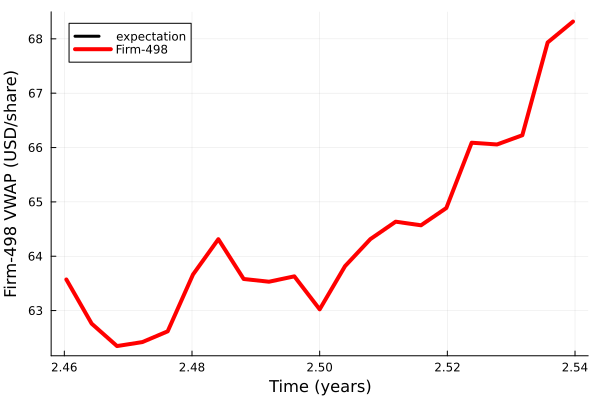

GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA


In [21]:
L68 = expectation[:,2] .- sqrt.(variance[:,2])
U68 = expectation[:,2] .+ sqrt.(variance[:,2])
L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

T_range = range(start_index,stop=stop_index-1,step=1) |> collect 
T_sim = T_range*Δt .- Δt

plot(T_sim, expectation[:,2], fillrange=L68, c=colors[5], alpha=0.3, label="")
plot!(T_sim, expectation[:,2], fillrange=U68, c=colors[6], alpha=0.3, label="")
plot!(T_sim, expectation[:,2], fillrange=L95, c=colors[5], alpha=0.2, label="")
plot!(T_sim, expectation[:,2], fillrange=U95, c=colors[6], alpha=0.2, label="")
plot!(T_sim, expectation[:,2], fillrange=L99, c=colors[5], alpha=0.1, label="")
plot!(T_sim, expectation[:,2], fillrange=U99, c=colors[6], alpha=0.1, label="")
plot!(T_sim, expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
plot!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price],  
    lw=4, c=:red, label="Firm-$(random_firm_index)", legend = :topleft)

xlabel!("Time (years)", fontsize=18)
ylabel!("Firm-$(random_firm_index) VWAP (USD/share)", fontsize=18)

The black dashed line is the expected share price predicted by the lattice model, while the shaded regions denote $\mu\pm{z}\cdot\sigma$ for $z=1.0,1.96,2.576$. The solid red line is the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for this firm, and date range.

### Was this a successful simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a straightforward functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [22]:
L = L99
U = U99
   
# check the bounds: if below L, or above U then simulation failed
success_flag = true;
for k ∈ 1:T
    if (random_firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (random_firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
        success_flag = false;
        break;
    end
end

println("The simultion of the VWAP of Firm-$(random_firm_index) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")

The simultion of the VWAP of Firm-498 between (621 -> 642) was successful: true


Q3.3: Find an example of a firm and time period that results in a successful simulation. Why do you think this simulation was successful?